In [1]:
import os

os.chdir("..")

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np
import tensorflow as tf

import json

from IPython.display import display
import plotly
import plotly.graph_objs as go
import cufflinks as cf
cf.go_offline()

from jalef.statistics import evaluate_result
from jalef.plots import plot_confusion_matrix, enable_plotly_in_cell

from jalef.preprocessing import BertPreprocessor
from jalef.layers import Bert

In [3]:
np.random.seed(1234)
tf.set_random_seed(1234)

In [4]:
# constatnts
MAX_SEQ_LEN = 128
MIN_SEQ_LEN = int(MAX_SEQ_LEN / 2)
DATASET_PATH = "data/coursera_dataset_top100/"
TEST_NAME = "dataset=coursera_intents=100"
N_INTENTS = 100
PRETRAINED_MODEL_PATH = "./models/bert/"
# modify if model changed to other H-XXXX!!!!
OUTPUT_SIZE = 1024

In [5]:
def select_errors(y_true, y_pred, preds, reverse_lut):
    df = pd.DataFrame(columns=["True", "True %", "Predicted", "Predicted %"])
    
    for i, t, p, p_probs in zip(range(len(y_true)), y_true, y_pred, preds):
        if t != p:
            t, p_probs[reverse_lut.loc[t]["Label"]], p, p_probs[reverse_lut.loc[p]["Label"]]
            df.loc[i] = [t, 
                         "{:.2f}".format(p_probs[reverse_lut.loc[t]["Label"]]), 
                         p, 
                         "{:.2f}".format(p_probs[reverse_lut.loc[p]["Label"]])
                        ]
            
    return df

In [6]:
def remove_uncertain_preds(y_true, y_pred, preds, threshold):
    ids = [idx for idx, p_probs in enumerate(preds) if max(p_probs) > threshold]
    return y_true[ids], y_pred[ids], preds[ids] 

In [19]:
def compare_thresholds(y_true, y_pred, preds, thresholds):
    df = pd.DataFrame(columns=["Predictions (or.)", "Predictions", "Predictions % (or.)", "Uncertain", "Uncertain % (or.)", "True", "True %", "True % (or.)", "False", "False %", "False % (or.)", "F/T ratio"])
    for t in thresholds:
        y_true_c, y_pred_c, _ = remove_uncertain_preds(y_true, y_pred, preds, t)

        n_removed = len(y_pred)-len(y_pred_c)
        n_err_c = len([i for i, j in zip(y_true_c, y_pred_c) if i != j])
        n_corr_c = len(y_pred_c) - n_err_c
        
        #df = df.append({'A': i}, ignore_index=True)
        df.loc[t] = ["{:.2f}".format(len(y_true)),
                     "{:.2f}".format(len(y_true_c)), 
                     "{:.2f}".format(len(y_true_c)/len(y_true)*100),
                     "{:.2f}".format(n_removed),
                     "{:.2f}".format(n_removed/len(y_true)*100),
                     "{:.2f}".format(n_corr_c),
                     "{:.2f}".format(n_corr_c/len(y_true_c)*100),
                     "{:.2f}".format(n_corr_c/len(y_true)*100),
                     "{:.2f}".format(n_err_c),
                     "{:.2f}".format(n_err_c/len(y_true_c)*100),
                     "{:.2f}".format(n_err_c/len(y_true)*100),
                     "{:.2f}".format(n_err_c/n_corr_c)
                    ]
        
    def green_color(e):
        return 'color: green'
    
    def orange_color(e):
        return 'color: orange'
    
    df = df.style.applymap(green_color, subset=["Predictions (or.)", "Uncertain % (or.)", "True % (or.)", "False % (or.)"])\
        .applymap(orange_color, subset=["Predictions", "True %", "False %"])
    
    display(df)

In [8]:
dataset = pd.read_csv(DATASET_PATH + "test.csv")
lut = pd.read_csv(DATASET_PATH + "lut.csv", names=["Intent"], index_col=0, header=0)
reverse_lut = pd.read_csv(DATASET_PATH + "lut.csv", names=["Label"], index_col=1, header=0)

dataset["Intent"] = [lut.at[label, "Intent"] for label in dataset["Label"].values]

print("The test set has {} rows.".format(len(dataset)))
display(dataset.head(3))
# print("The LUT:")
# display(lut)

The test set has 5340 rows.


Text  Label  \
0  These things that we normally consider poisons...     40   
1  So, many similar themes are addressed here, bu...     59   
2  So this structure here, where you, all you hav...     19   

                    Intent  
0         forensic-science  
1  organizational-analysis  
2             neurobiology

In [9]:
enable_plotly_in_cell()

dataset.groupby("Intent").count().sort_values(by=["Label"], ascending=False)["Label"].iplot(
    kind="bar",
    xTitle="Intent",
    yTitle="Count",
    title="Intent distribution in dataset",
    tickfont=dict(
        size=9,
    ),
)

In [10]:
bp = BertPreprocessor(max_sequence_length=MAX_SEQ_LEN, pretrained_model_path=PRETRAINED_MODEL_PATH)

W0801 13:20:53.925081 140002506970944 deprecation_wrapper.py:119] From /app/jalef/preprocessing/bert_preprocessor.py:26: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0801 13:20:54.816013 140002506970944 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/bert/tokenization.py:125: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.



In [11]:
X_test,  y_test  = bp.fit_transform_classification(dataset["Text"].values, dataset["Label"].values)

In [12]:
# create model from saved configs and load best weights
with tf.keras.utils.CustomObjectScope({'Bert': Bert}):
    with open("logs/configs/" + TEST_NAME + "_configs.json") as file:
        json_str = json.load(file)
        model = tf.keras.models.model_from_json(json_str)
model.load_weights("logs/weights/" + TEST_NAME + "_weights.hdf5")

W0801 13:21:07.963367 140002506970944 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0801 13:21:07.963937 140002506970944 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0801 13:21:07.964855 140002506970944 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Orthogonal.__init__ (from tensorflow.python.ops.init_ops) with

In [13]:
preds = model.predict(x=[X_test[0], X_test[1], X_test[2]])

In [14]:
y_pred = np.array([lut.at[np.argmax(e), "Intent"] for e in preds])
y_true = np.array([lut.at[np.argmax(e), "Intent"] for e in y_test])

print(y_true[:2])
print(y_pred[:2])

['forensic-science' 'organizational-analysis']
['forensic-science' 'organizational-analysis']


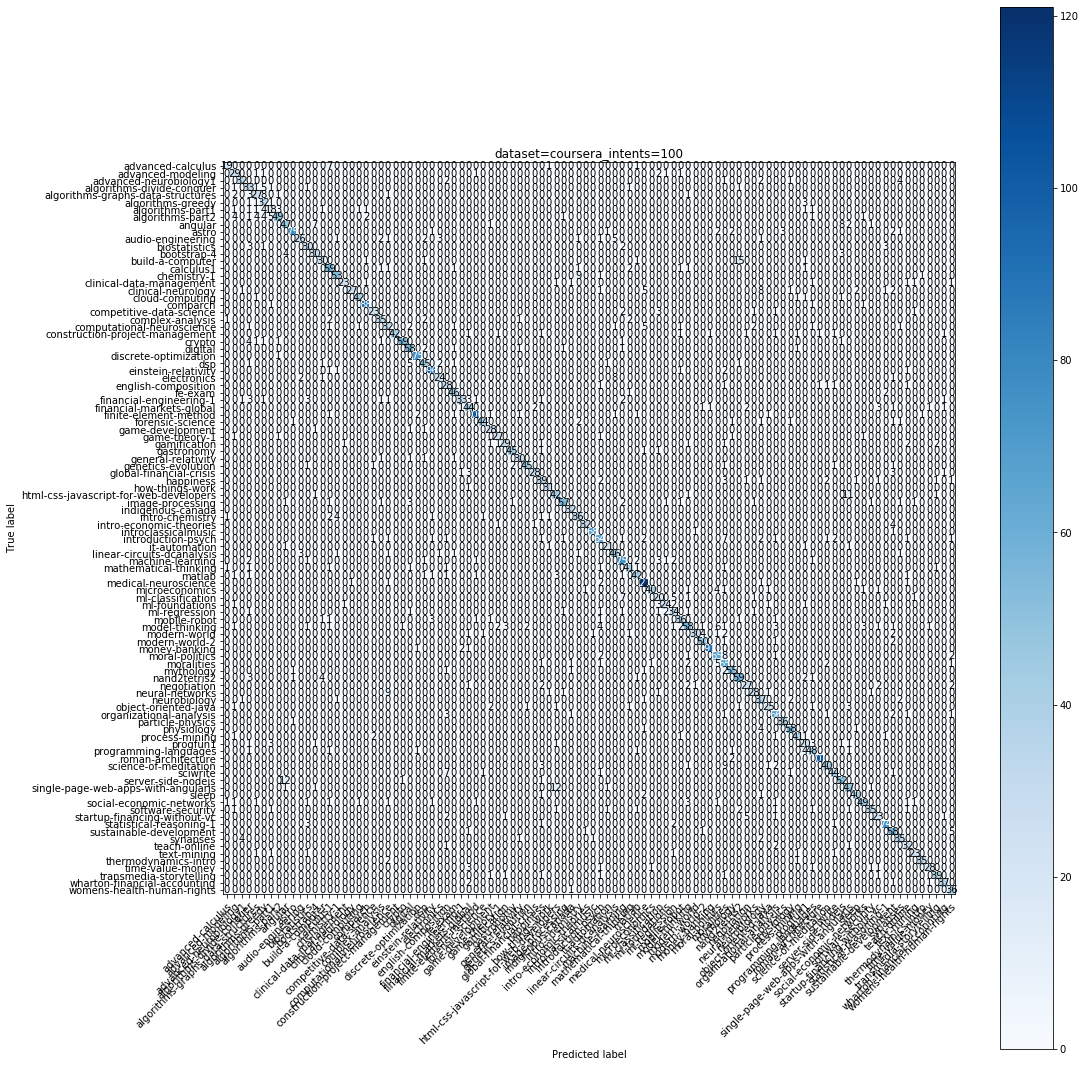

In [15]:
plot_confusion_matrix(y_true=y_true, y_pred=y_pred, normalize=False, title=TEST_NAME)

In [16]:
print("These are the cases, where the classifier predicts the wrong class:")
errors = select_errors(y_true, y_pred, preds, reverse_lut)
display(errors)

These are the cases, where the classifier predicts the wrong class:


True True %  \
6                           machine-learning   0.00   
11                            model-thinking   0.18   
17                    advanced-neurobiology1   0.00   
27                                physiology   0.03   
31                            modern-world-2   0.00   
33                               bootstrap-4   0.27   
37                computational-neuroscience   0.43   
40                          time-value-money   0.28   
41                           intro-chemistry   0.00   
52                               negotiation   0.00   
56                             ml-regression   0.00   
57         algorithms-graphs-data-structures   0.00   
75                              nand2tetris2   0.00   
76                              gamification   0.05   
78                computational-neuroscience   0.00   
84                   global-financial-crisis   0.00   
86                          algorithms-part2   0.00   
88                          algorithms-part2   0.00   
89                              neurobiology   0.02   
94                                 happiness   0.06   
95                                       dsp   0.09   
96                          time-value-money   0.17   
97                            model-thinking   0.00   
101                         time-value-money   0.00   
102                  financial-engineering-1   0.00   
110                             mobile-robot   0.02   
122                         image-processing   0.08   
126                  intro-economic-theories   0.00   
150                  global-financial-crisis   0.00   
153                               moralities   0.00   
162                      introclassicalmusic   0.42   
163                          intro-chemistry   0.14   
164                  organizational-analysis   0.20   
168                       clinical-neurology   0.02   
172                         build-a-computer   0.00   
181                    mathematical-thinking   0.00   
207                       clinical-neurology   0.03   
211                           moral-politics   0.07   
216                         algorithms-part1   0.01   
225                  financial-engineering-1   0.07   
227                                      dsp   0.09   
228                                mythology   0.10   
232                   advanced-neurobiology1   0.00   
239                                calculus1   0.27   
240                                  angular   0.46   
244                           microeconomics   0.00   
252                             modern-world   0.23   
258                     object-oriented-java   0.00   
262                           model-thinking   0.02   
271                         image-processing   0.00   
280                          neural-networks   0.00   
293                                   crypto   0.03   
297                         build-a-computer   0.12   
301                             neurobiology   0.00   
315                    programming-languages   0.03   
318                         algorithms-part2   0.01   
326                               moralities   0.01   
342                 financial-markets-global   0.25   
345                                happiness   0.07   
349                           model-thinking   0.26   
354                        audio-engineering   0.03   
357                             nand2tetris2   0.06   
359                  statistical-reasoning-1   0.00   
379                            game-theory-1   0.00   
382                             nand2tetris2   0.16   
389                            money-banking   0.26   
391                       server-side-nodejs   0.02   
404                                 sciwrite   0.00   
421                         algorithms-part1   0.03   
422                            ml-regression   0.00   
427                             gamification   0.00   
429                        ml-classification   0.04   
444                      

In [17]:
errors.groupby("True").count().sort_values(by=["Predicted"], ascending=False)["Predicted"].iplot(
    kind="bar",
    xTitle="Intent",
    yTitle="Count",
    title="Mislabelled intents",
    tickfont=dict(
        size=8,
    ),
)

In [20]:
print("Number of intents: {}".format(len(preds[0])))

compare_thresholds(y_true, y_pred, preds, [0, 0.7, 0.8, 0.85, 0.9, 0.95])

Number of intents: 100


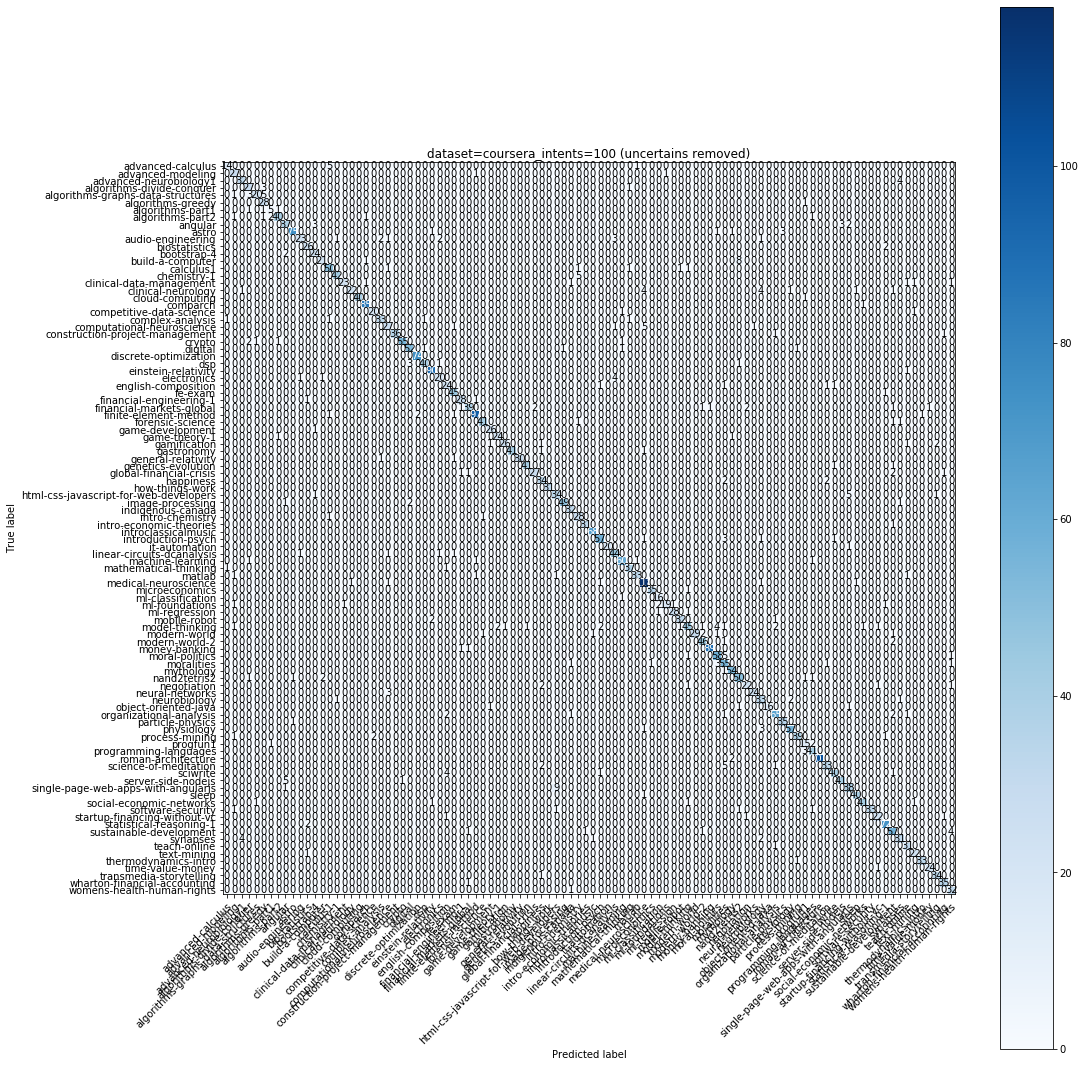

In [21]:
y_true_c, y_pred_c, preds_c = remove_uncertain_preds(y_true, y_pred, preds, 0.95)
errors_c = select_errors(y_true_c, y_pred_c, preds_c, reverse_lut)

plot_confusion_matrix(y_true=y_true_c, y_pred=y_pred_c, normalize=False, title=TEST_NAME + " (uncertains removed)")

errors_c.groupby("True").count().sort_values(by=["Predicted"], ascending=False)["Predicted"].iplot(
    kind="bar",
    xTitle="Intent",
    yTitle="Count",
    title="Mislabelled intents (uncertains removed)",
    tickfont=dict(
        size=8,
    ),
)